In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

#costume classes
from nexus_ai.sentence_sentiment_analysis.model import SentimentRNN
from nexus_ai.sentence_sentiment_analysis.model_utilities import train, test, predict
from nexus_ai.sentence_sentiment_analysis.preprocessing import clean_reviews, creat_vocab, tokenize_data, pad_features, train_test_split, google_clean_reviews, clean_reviews_and_creat_vocab

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meshari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# loading and exploring the data:

In [2]:
df_review = pd.read_pickle('yelp_balanced_60_positive.pkl')

In [3]:
df_review.shape

(4935445, 2)

<BarContainer object of 2 artists>

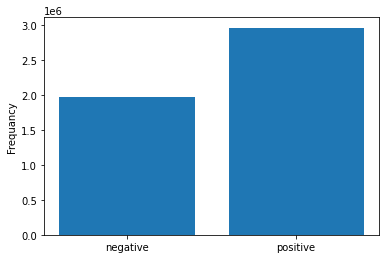

In [4]:
#plotting the distrubution of positive/negative reviews
plt.figure()

plt.ylabel('Frequancy')
plt.xticks([1, 0],['positive','negative'])

plt.bar([1, 0],df_review['stars'].value_counts())

# preprocessing the data:

In [5]:
#converting the dataframe to two lists one for reviews and one for labels
reviews = list(df_review['text'])
labels = list(df_review['stars'])

In [6]:
#freeing up memory by removing unnecessary data from it
df_review = None

In [7]:
#cleaning up the reviews and creating a vocablary containing words mentioned more than 100 times in the whole dataset 
#the vocablary is ordered so that the most mentioned words would come first
# reviews, vocab_to_int = clean_reviews_and_creat_vocab(reviews, greater_than=100, stopwords_=True, stemm=True)
reviews, vocab_to_int = clean_reviews_and_creat_vocab(reviews, greater_than=100)

In [8]:
print(len(vocab_to_int))

40954


In [9]:
#printing the highest 20 words mentioned in the data
for vocab, stop in zip(vocab_to_int.keys(), range(20)):
    print(vocab)

||*Period*||
the
||*Comma*||
and
i
to
a
||*Return*||
was
of
it
for
in
is
||*Exclamation_mark*||
my
that
they
this
with


In [10]:
#tockenizing the reviews by converting words to numbers that's unique to each word
#tockenizing the labels by converting positive/negative to 1/0
reviews_ints, encoded_labels = tokenize_data(reviews, labels, vocab_to_int)

# getting rid of outliers:

In [11]:
# encoded_labels = encoded_labels.tolist()

In [12]:
# non_high_len_idx = [i for i in range(len(reviews_ints)) if review_lengths[i] < 1000]
# print('number of remaining elements {}'.format(len(non_high_len_idx)))
# print('the deleted elements would be {}'.format(len(review_lengths)-len(non_high_len_idx)))

In [13]:
# print(len(reviews_ints))
# print(len(encoded_labels))
# print(len(review_lengths))
# print('avarege length is', statistics.mean(review_lengths))
# print('the max length is', max(review_lengths))
# print('the min length is', min(review_lengths))

In [14]:
# reviews_ints = [reviews_ints[i] for i in non_high_len_idx]
# encoded_labels = [encoded_labels[i] for i in non_high_len_idx]
# review_lengths = [len(review) for review in reviews_ints]

In [15]:
# print(len(reviews_ints))
# print(len(encoded_labels))
# print(len(review_lengths))
# print('avarege length is', statistics.mean(review_lengths))
# print('the max length is', max(review_lengths))
# print('the min length is', min(review_lengths))

In [16]:
# non_short_len_idx = [i for i in range(len(review_lengths)) if review_lengths[i] > 5]
# print('number of remaining elements {}'.format(len(non_short_len_idx)))
# print('the deleted elements would be {}'.format(len(review_lengths)-len(non_short_len_idx)))

In [17]:
# reviews_ints = [reviews_ints[i] for i in non_short_len_idx]
# encoded_labels = [encoded_labels[i] for i in non_short_len_idx]
# review_lengths = [len(review) for review in reviews_ints]

In [18]:
# print(len(reviews_ints))
# print(len(encoded_labels))
# print(len(review_lengths))
# print('avarege length is', statistics.mean(review_lengths))
# print('the max length is', max(review_lengths))
# print('the min length is', min(review_lengths))

In [19]:
# encoded_labels = np.array(encoded_labels)

In [20]:
# #plotting the length of the reviews to choose an appropriate sequence length
# import statistics
# review_lengths = [len(review) for review in reviews_ints]

# print('avarege length is', statistics.mean(review_lengths))
# print('the max length is', max(review_lengths))
# print('the min length is', min(review_lengths))

# plt.figure()

# plt.hist(review_lengths, bins=5)

# plt.show()

avarege length is 137.32506289953642
the max length is 2472
the min length is 1


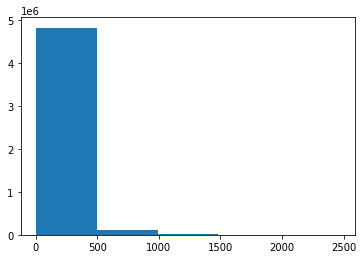

In [21]:
#plotting the length of the reviews to choose an appropriate sequence length
import statistics
review_lengths = [len(review) for review in reviews_ints]

print('avarege length is', statistics.mean(review_lengths))
print('the max length is', max(review_lengths))
print('the min length is', min(review_lengths))

plt.figure()

plt.hist(review_lengths, bins=5)

plt.show()

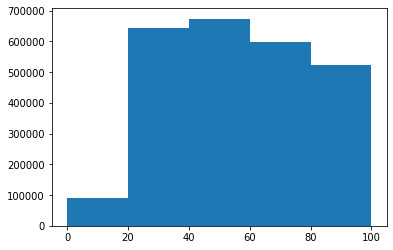

In [22]:
# plot with a range of 100
plt.figure()

plt.hist(review_lengths, range=(0, 100), bins=5)

plt.show()

positive avarege length is 119.84815369293496
positive max length is 1397
positive min length is 1


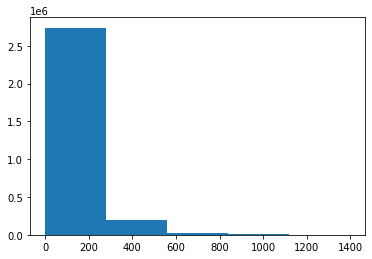

In [23]:
pos_review_lengths = [len(review) for i, review in enumerate(reviews_ints) if encoded_labels[i]==1]

print('positive avarege length is', statistics.mean(pos_review_lengths))
print('positive max length is', max(pos_review_lengths))
print('positive min length is', min(pos_review_lengths))

plt.figure()

plt.hist(pos_review_lengths, bins=5)

plt.show()

negative avarege length is 163.5387092754554
negative max length is 2472
negative min length is 1


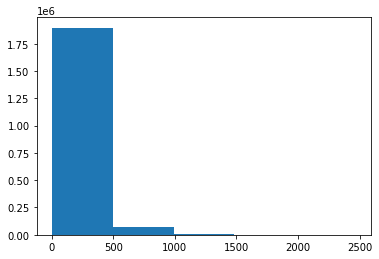

In [24]:
neg_review_lengths = [len(review) for i, review in enumerate(reviews_ints) if encoded_labels[i]==0]

print('negative avarege length is', statistics.mean(neg_review_lengths))
print('negative max length is', max(neg_review_lengths))
print('negative min length is', min(neg_review_lengths))

plt.figure()

plt.hist(neg_review_lengths, bins=5)

plt.show()

# preparing and splitting the dataset:

In [25]:
#the sequence length is 80 because of the length of google reviews seems to in this range
#and it's also approriate for the yelp dataset
seq_length = 80
features = pad_features(reviews_ints, seq_length)

In [26]:
#splitting the reviews and labels into training, validiting, testing sets
train_x, validate_x, test_x, train_y, validate_y, test_y = train_test_split(features, encoded_labels, ordered_by_labels=True)

In [27]:
## print out the shapes of resultant feature data
print(train_x.shape)
print(train_y.shape)
print(validate_x.shape)
print(validate_y.shape)
print(test_x.shape)
print(test_y.shape)
# testing equality of distrubution for pos/neg
print('training data distrubution (precentage of positive data): {} %'.format((train_y.sum()/train_y.shape[0])*100))
print('validating data distrubution (precentage of positive data): {} %'.format((validate_y.sum()/validate_y.shape[0])*100))
print('testing data distrubution (precentage of positive data): {} %'.format((test_y.sum()/test_y.shape[0])*100)) 

(3948200, 80)
(3948200,)
(493524, 80)
(493524,)
(493524, 80)
(493524,)
training data distrubution (precentage of positive data): 50.0 %
validating data distrubution (precentage of positive data): 99.98419529749313 %
testing data distrubution (precentage of positive data): 100.0 %


In [28]:
#creating data loaders to be used in training and testing 

train_data = TensorDataset(torch.from_numpy(features), torch.from_numpy(encoded_labels))
valid_data = TensorDataset(torch.from_numpy(validate_x), torch.from_numpy(validate_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

#batch_size for dataloaders
batch_size = 256

num_worker = 0

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_worker)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_worker)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_worker)

In [29]:
#freeing up memory by removing unnecessary data from it
# reviews = None
# labels = None
# reviews_ints
# encoded_labels = None
# features = None
# train_x = None
# validate_x = None
# test_x = None
# train_y = None
# validate_y = None
# test_y = None

# defining and training the model:

In [30]:
#make sure the gpu is avalibale before moving the data to It else the work would be done using the cpu
train_on_gpu=torch.cuda.is_available()

#specifing the model hypermetrs and creating the model
vocab_size = len(vocab_to_int)+1
output_size = 1
embedding_dim = 300
hidden_dim = 200
n_layers = 2
 
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, train_on_gpu=train_on_gpu,
                   bidirectional=False, drop_prob=0.3)

print(net)

# loss and optimization functions

lr=0.0001
criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=0.00001)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

SentimentRNN(
  (embd): Embedding(40955, 300)
  (lstm): LSTM(300, 200, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [163]:
# training the model
train(net, train_loader, valid_loader, optimizer, vocab_to_int, batch_size, seq_length=seq_length, epochs=1,
      print_every=1, train_on_gpu=train_on_gpu, save_dic='yelp_test21.pth')

Epoch: 1/1... Step: 19278... Loss: 0.120001... Val Loss: 0.077971
Validation loss decreased (inf --> 0.077971).  Saving model ...


# testing and validating the model:

In [164]:
# testing the model
test(test_loader, train_on_gpu, batch_size, net=net)

Test loss: 0.079
Test accuracy: 0.967


In [165]:
# testing the last saved model
test(test_loader, train_on_gpu, batch_size, model_path='yelp_test21.pth')

Test loss: 0.079
Test accuracy: 0.967


In [166]:
# testing on a positive review
test_review_pos = 'Calm work space caféIn love with the iced Peanut butter latte!!You can reserve meeting rooms per hour at reasonable prices..Nice soothing musicTotally recommend it'

predict(reviews=test_review_pos, train_on_gpu=train_on_gpu, vocab_to_int=vocab_to_int, seq_length=seq_length, net=net)

'positive'

In [167]:
# testing using google data with 26,000 reviews 
data = pd.read_json('REVIEWS_DATA_SET_26K_EN.json')
# reviews, labels, words = google_clean_reviews(data, stopwords_=True, stemm=True)
data = google_clean_reviews(data)
reviews = list(df['text'])
labels = list(df['rating'])

In [168]:
# testing the google dataset on the model
predict(reviews=reviews, labels=labels, gpu=True, seq_length=seq_length, vocab_to_int=vocab_to_int, net=net, 
        stats=True, use_labels=True)

accuracy = 92.01%
recall = 92.39%
Precision  = 98.72%
F1 score  = 95.45%
TP:22302, TN:2196, FN:1836, FP:290


,reviews,labels,pred
0,stopped off here as we were looking for somewh...,1,1.0
1,what a great restaurant ||*Period*|| we went ...,1,1.0
2,boy ||*Comma*|| am i glad i got to try da mar...,1,1.0
3,we found this gem during our mini trip to expe...,1,1.0
4,donna the bartender is amazing ||*Period*|| s...,1,1.0
...,...,...,...
26619,they have really a good burger using a good qu...,1,1.0
26620,high price ||*Period*|| ||*Period*|| bad fo...,0,0.0
26621,this was a nice sit down restaurant with food ...,0,0.0
26622,i went for a dinner sunday ||*Comma*|| reserv...,0,0.0


In [169]:
# testing the google dataset using the last saved model
predict(reviews=reviews, labels=labels, gpu=True, seq_length=seq_length, vocab_to_int=vocab_to_int,
        model_path='yelp_test21.pth', stats=True, use_labels=True)

accuracy = 92.01%
recall = 92.39%
Precision  = 98.72%
F1 score  = 95.45%
TP:22302, TN:2196, FN:1836, FP:290


,reviews,labels,pred
0,stopped off here as we were looking for somewh...,1,1.0
1,what a great restaurant ||*Period*|| we went ...,1,1.0
2,boy ||*Comma*|| am i glad i got to try da mar...,1,1.0
3,we found this gem during our mini trip to expe...,1,1.0
4,donna the bartender is amazing ||*Period*|| s...,1,1.0
...,...,...,...
26619,they have really a good burger using a good qu...,1,1.0
26620,high price ||*Period*|| ||*Period*|| bad fo...,0,0.0
26621,this was a nice sit down restaurant with food ...,0,0.0
26622,i went for a dinner sunday ||*Comma*|| reserv...,0,0.0


In [170]:
# testing with balanced google data
data = pd.read_json('google_balanced.json')
reviews, labels = google_clean_reviews(data)
reviews = list(df['text'])
labels = list(df['rating'])

In [171]:
# testing the balanced google dataset on the model
predict(reviews=reviews, labels=labels, gpu=True, seq_length=seq_length, net=net,
        vocab_to_int=vocab_to_int, stats=True, use_labels=True)

accuracy = 89.46%
recall = 90.59%
Precision  = 88.59%
F1 score  = 89.58%
TP:2252, TN:2196, FN:234, FP:290


,reviews,labels,pred
0,i was extremely impressed by mohamed ali taala...,1,1.0
1,very nice food ||*Comma*|| very nice service ...,1,1.0
2,nisce service from abhishek and delicious food...,1,1.0
3,thank you so much for good delicious food and ...,1,1.0
4,superb venue ||*Comma*|| very friendly ||*Com...,1,1.0
...,...,...,...
4967,we found a place close to book of mormon ||*Co...,0,0.0
4968,after doing lots of research and poring over n...,0,0.0
4969,we went there with a party of 5 european trave...,0,0.0
4970,generally the atmosphere is very good ||*Perio...,0,0.0


In [172]:
# testing the balanced google dataset using the last saved model
predict(reviews=reviews, labels=labels, gpu=True, model_path='yelp_test21.pth', stats=True, use_labels=True)

accuracy = 89.46%
recall = 90.59%
Precision  = 88.59%
F1 score  = 89.58%
TP:2252, TN:2196, FN:234, FP:290


,reviews,labels,pred
0,i was extremely impressed by mohamed ali taala...,1,1.0
1,very nice food ||*Comma*|| very nice service ...,1,1.0
2,nisce service from abhishek and delicious food...,1,1.0
3,thank you so much for good delicious food and ...,1,1.0
4,superb venue ||*Comma*|| very friendly ||*Com...,1,1.0
...,...,...,...
4967,we found a place close to book of mormon ||*Co...,0,0.0
4968,after doing lots of research and poring over n...,0,0.0
4969,we went there with a party of 5 european trave...,0,0.0
4970,generally the atmosphere is very good ||*Perio...,0,0.0


In [ ]:
#seq length = 80
# vocab_size = len(vocab_to_int)+1
# output_size = 1
# embedding_dim = 300
# hidden_dim = 200
# n_layers = 2
#lr=0.0001